<a href="https://colab.research.google.com/github/ameralhomdy/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd

ufc = pd.read_csv('ufc_combined.csv')

ufc.head()

,Unnamed: 0,fighter1,fighter2,winner,weight_class,title_fight,method,end_round,fight_year,win_fighter1,lose_fighter1,draw_fighter1,nc_fighter1,height_fighter1,reach_fighter1,stance_fighter1,SLpM_fighter1,Str_Acc_fighter1,SApM_fighter1,Str_Def_fighter1,TD_Avg_fighter1,TD_Acc_fighter1,TD_Def_fighter1,Sub_Avg_fighter1,win%_fighter1,born_year_fighter1,win_fighter2,lose_fighter2,draw_fighter2,nc_fighter2,height_fighter2,reach_fighter2,stance_fighter2,SLpM_fighter2,Str_Acc_fighter2,SApM_fighter2,Str_Def_fighter2,TD_Avg_fighter2,TD_Acc_fighter2,TD_Def_fighter2,Sub_Avg_fighter2,win%_fighter2,born_year_fighter2
0,0,Santiago Ponzinibbio,Neil Magny,1,Welterweight,f,KO/TKO,4,2018,28,3,0,0,"6' 0""","73""",Orthodox,4.27,39.0,4.02,64.0,0.54,44.0,60.0,0.0,90.322580,1986,21,8,0,0,"6' 3""","80""",Orthodox,3.86,46.0,2.22,56.0,2.62,46.0,60.0,0.3,72.413795,1987
1,1,Ricardo Lamas,Darren Elkins,1,Featherweight,f,KO/TKO,3,2018,19,7,0,0,"5' 8""","71""",Orthodox,2.87,45.0,2.61,59.0,1.66,32.0,47.0,1.0,73.076920,1982,25,7,0,0,"5' 10""","71""",Orthodox,3.36,37.0,2.83,53.0,2.68,35.0,57.0,1.3,78.125000,1984
2,2,Johnny Walker,Khalil Rountree Jr.,1,Light Heavyweight,f,KO/TKO,1,2018,15,3,0,0,"6' 5""","82""",Orthodox,5.37,70.0,3.36,25.0,0.89,100.0,100.0,2.6,83.333336,1992,8,2,0,2,"6' 1""","76""",Southpaw,2.30,34.0,3.29,38.0,0.00,0.0,50.0,0.3,66.666664,1990
3,3,Cezar Ferreira,Ian Heinisch,0,Middleweight,f,DEC,3,2018,14,7,0,0,"6' 1""","78""",Southpaw,1.83,42.0,2.14,55.0,2.97,59.0,90.0,0.5,66.666664,1985,12,1,0,0,"5' 11""",NaN,Orthodox,3.49,58.0,1.67,52.0,0.81,14.0,50.0,1.6,92.307690,1988
4,4,Marlon Vera,Guido Cannetti,1,Bantamweight,f,SUB,2,2018,12,5,1,0,"5' 8""","70""",Switch,3.23,44.0,3.93,52.0,0.78,37.0,68.0,1.3,66.666664,1992,8,5,0,0,"5' 6""","68""",Southpaw,2.80,52.0,1.95,51.0,2.80,50.0,75.0,0.3,61.538460,1979


In [0]:
# dropping columns that we won't have info on for predicting in the future

dropped_columns = ['method', 'end_round', 'Unnamed: 0', 'stance_fighter1', 'stance_fighter2']

ufc = ufc.drop(columns=dropped_columns)

In [4]:
# splitting into test and train
train = ufc[ufc['fight_year'] <= 2016]
test = ufc[ufc['fight_year'] > 2016]

train.shape, test.shape

((3748, 38), (843, 38))

In [0]:
# splitting into X features and y target

target = 'winner'

X_train = train.drop(columns=[target])
y_train = train[target]
X_test = test.drop(columns=[target])
y_test = test[target]

In [6]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_test_transformed = transformers.transform(X_test)

model = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_test_transformed)

print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.7295373665480427


In [7]:
from xgboost import XGBClassifier

columns = ['TD_Def_fighter1','Str_Acc_fighter2','TD_Def_fighter2','Str_Acc_fighter1',
           'born_year_fighter2','born_year_fighter1','height_fighter1','height_fighter2']
X_train_2 = X_train.drop(columns=columns)
X_test_2 = X_test.drop(columns=columns)

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train_2, y_train)

y_pred = pipeline.predict(X_test_2)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.7520759193357058


In [8]:
X_test_2.head()

,fighter1,fighter2,weight_class,title_fight,fight_year,win_fighter1,lose_fighter1,draw_fighter1,nc_fighter1,reach_fighter1,SLpM_fighter1,SApM_fighter1,Str_Def_fighter1,TD_Avg_fighter1,TD_Acc_fighter1,Sub_Avg_fighter1,win%_fighter1,win_fighter2,lose_fighter2,draw_fighter2,nc_fighter2,reach_fighter2,SLpM_fighter2,SApM_fighter2,Str_Def_fighter2,TD_Avg_fighter2,TD_Acc_fighter2,Sub_Avg_fighter2,win%_fighter2
0,Santiago Ponzinibbio,Neil Magny,Welterweight,f,2018,28,3,0,0,"73""",4.27,4.02,64.0,0.54,44.0,0.0,90.322580,21,8,0,0,"80""",3.86,2.22,56.0,2.62,46.0,0.3,72.413795
1,Ricardo Lamas,Darren Elkins,Featherweight,f,2018,19,7,0,0,"71""",2.87,2.61,59.0,1.66,32.0,1.0,73.076920,25,7,0,0,"71""",3.36,2.83,53.0,2.68,35.0,1.3,78.125000
2,Johnny Walker,Khalil Rountree Jr.,Light Heavyweight,f,2018,15,3,0,0,"82""",5.37,3.36,25.0,0.89,100.0,2.6,83.333336,8,2,0,2,"76""",2.30,3.29,38.0,0.00,0.0,0.3,66.666664
3,Cezar Ferreira,Ian Heinisch,Middleweight,f,2018,14,7,0,0,"78""",1.83,2.14,55.0,2.97,59.0,0.5,66.666664,12,1,0,0,NaN,3.49,1.67,52.0,0.81,14.0,1.6,92.307690
4,Marlon Vera,Guido Cannetti,Bantamweight,f,2018,12,5,1,0,"70""",3.23,3.93,52.0,0.78,37.0,1.3,66.666664,8,5,0,0,"68""",2.80,1.95,51.0,2.80,50.0,0.3,61.538460


In [14]:
import eli5
from eli5.sklearn import PermutationImportance

encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train_2)
X_test_encoded = encoder.transform(X_test_2)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_encoded, y_train)

y_pred = model.predict(X_test_encoded)

print('Test Accuracy', accuracy_score(y_test, y_pred))

permuter = PermutationImportance(
    pipeline,
    scoring='accuracy',
    n_iter=5,
    random_state=42
)

permuter.fit(X_test_encoded, y_test)

Test Accuracy 0.7520759193357058


PermutationImportance(cv='prefit',
                      estimator=Pipeline(memory=None,
                                         steps=[('ordinalencoder',
                                                 OrdinalEncoder(cols=['fighter1',
                                                                      'fighter2',
                                                                      'weight_class',
                                                                      'title_fight',
                                                                      'reach_fighter1',
                                                                      'reach_fighter2'],
                                                                drop_invariant=False,
                                                                handle_missing='value',
                                                                handle_unknown='value',
                                                                mappin

In [15]:
feature_names = X_test_2.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1276 ± 0.0098,win%_fighter2
0.0940 ± 0.0142,win%_fighter1
0.0368 ± 0.0169,win_fighter1
0.0361 ± 0.0111,win_fighter2
0.0339 ± 0.0118,SLpM_fighter2
0.0247 ± 0.0055,SApM_fighter1
0.0247 ± 0.0098,SLpM_fighter1
0.0187 ± 0.0074,Str_Def_fighter1
0.0180 ± 0.0113,TD_Acc_fighter1
0.0097 ± 0.0041,Sub_Avg_fighter2


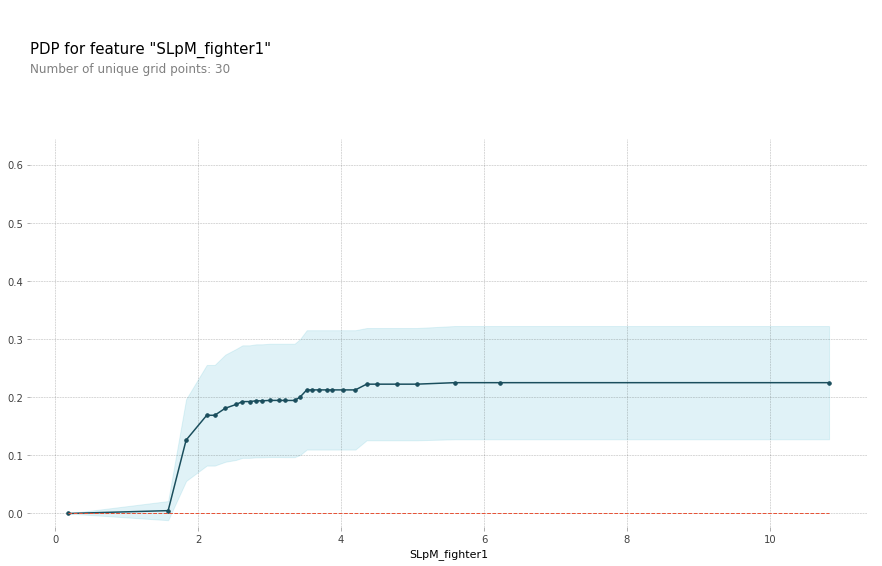

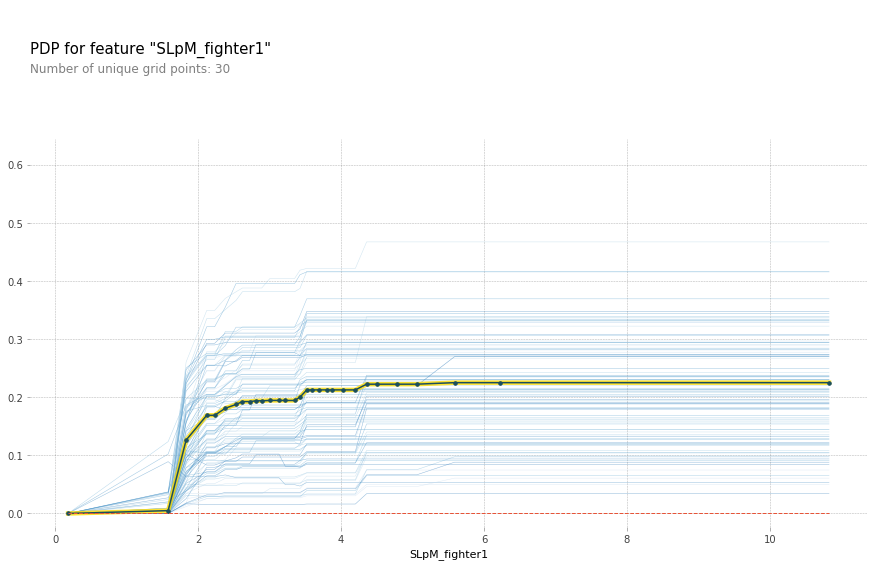

In [19]:
from pdpbox.pdp import pdp_isolate, pdp_plot
import matplotlib.pyplot as plt

feature = 'SLpM_fighter1'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_test_2, 
    model_features=X_test_2.columns, 
    feature=feature,
    num_grid_points=30
)

pdp_plot(isolated, feature_name=feature);

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.76       421
           1       0.77      0.72      0.74       422

    accuracy                           0.75       843
   macro avg       0.75      0.75      0.75       843
weighted avg       0.75      0.75      0.75       843



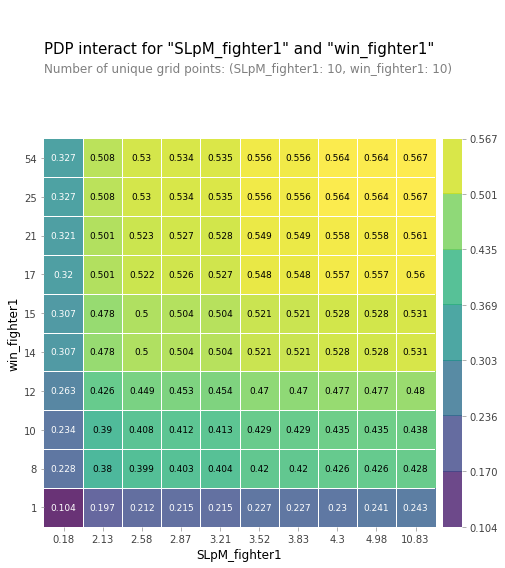

In [24]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['SLpM_fighter1', 'win_fighter1']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_test_2, 
    model_features=X_test_2.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [0]:
ufc.head()

,fighter1,fighter2,winner,weight_class,title_fight,fight_year,win_fighter1,lose_fighter1,draw_fighter1,nc_fighter1,height_fighter1,reach_fighter1,SLpM_fighter1,Str_Acc_fighter1,SApM_fighter1,Str_Def_fighter1,TD_Avg_fighter1,TD_Acc_fighter1,TD_Def_fighter1,Sub_Avg_fighter1,win%_fighter1,born_year_fighter1,win_fighter2,lose_fighter2,draw_fighter2,nc_fighter2,height_fighter2,reach_fighter2,SLpM_fighter2,Str_Acc_fighter2,SApM_fighter2,Str_Def_fighter2,TD_Avg_fighter2,TD_Acc_fighter2,TD_Def_fighter2,Sub_Avg_fighter2,win%_fighter2,born_year_fighter2
0,Santiago Ponzinibbio,Neil Magny,1,Welterweight,f,2018,28,3,0,0,"6' 0""","73""",4.27,39.0,4.02,64.0,0.54,44.0,60.0,0.0,90.322580,1986,21,8,0,0,"6' 3""","80""",3.86,46.0,2.22,56.0,2.62,46.0,60.0,0.3,72.413795,1987
1,Ricardo Lamas,Darren Elkins,1,Featherweight,f,2018,19,7,0,0,"5' 8""","71""",2.87,45.0,2.61,59.0,1.66,32.0,47.0,1.0,73.076920,1982,25,7,0,0,"5' 10""","71""",3.36,37.0,2.83,53.0,2.68,35.0,57.0,1.3,78.125000,1984
2,Johnny Walker,Khalil Rountree Jr.,1,Light Heavyweight,f,2018,15,3,0,0,"6' 5""","82""",5.37,70.0,3.36,25.0,0.89,100.0,100.0,2.6,83.333336,1992,8,2,0,2,"6' 1""","76""",2.30,34.0,3.29,38.0,0.00,0.0,50.0,0.3,66.666664,1990
3,Cezar Ferreira,Ian Heinisch,0,Middleweight,f,2018,14,7,0,0,"6' 1""","78""",1.83,42.0,2.14,55.0,2.97,59.0,90.0,0.5,66.666664,1985,12,1,0,0,"5' 11""",NaN,3.49,58.0,1.67,52.0,0.81,14.0,50.0,1.6,92.307690,1988
4,Marlon Vera,Guido Cannetti,1,Bantamweight,f,2018,12,5,1,0,"5' 8""","70""",3.23,44.0,3.93,52.0,0.78,37.0,68.0,1.3,66.666664,1992,8,5,0,0,"5' 6""","68""",2.80,52.0,1.95,51.0,2.80,50.0,75.0,0.3,61.538460,1979
